### INPUT DATA

In [1]:
import pandas as pd
df_airfoil = pd.read_csv('S809.dat', skiprows=3, delim_whitespace=True,
                 names=["x/c upper","y/c upper","x/c lower","y/c lower"])
df = pd.read_csv('ClCdS809.dat', skiprows=3, delim_whitespace=True,
                 names=["AoA", "C_L", "C_D"])

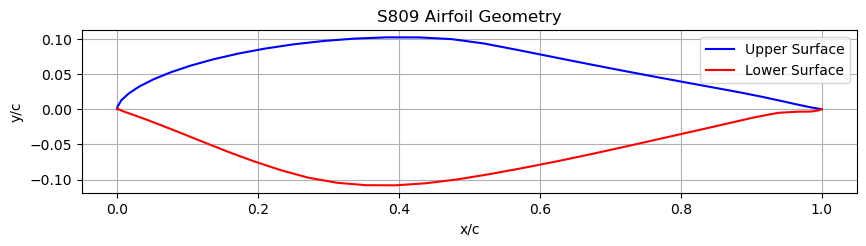

In [2]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot upper surface
plt.plot(df_airfoil['x/c upper'], df_airfoil['y/c upper'], label='Upper Surface', color='blue')

# Plot lower surface in reverse order to connect with upper surface
plt.plot(df_airfoil['x/c lower'], df_airfoil['y/c lower'][::-1], label='Lower Surface', color='red')

# Add labels and title
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.title('S809 Airfoil Geometry')

# Set equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add legend
plt.legend()

plt.grid(True)

# Show plot
plt.show()



In [4]:
u=12
d=150
z=3
tsr=5
Foil='S809'

#### AIR FOIL CHARACTERISTICS

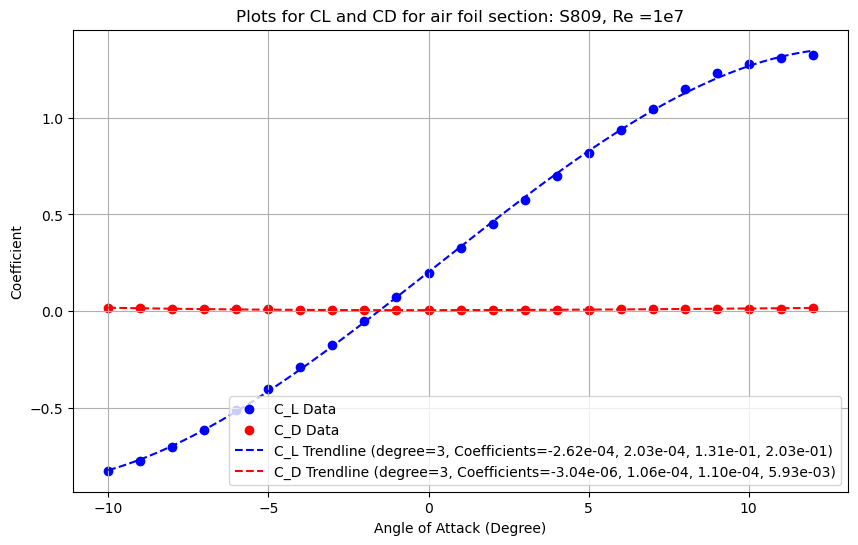

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Fit trendlines
degree = 3  # Degree of polynomial for trendline
coeff_CL = np.polyfit(df['AoA'], df['C_L'], degree)
coeff_CD = np.polyfit(df['AoA'], df['C_D'], degree)

# Generate smooth curve data
AoA_smooth = np.linspace(df['AoA'].min(), df['AoA'].max(), 100)
C_L_trendline = np.polyval(coeff_CL, AoA_smooth)
C_D_trendline = np.polyval(coeff_CD, AoA_smooth)

# Convert coefficients to strings
coeff_CL_str = ', '.join(f"{coeff:.2e}" for coeff in coeff_CL)
coeff_CD_str = ', '.join(f"{coeff:.2e}" for coeff in coeff_CD)

# Plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(df['AoA'], df['C_L'], label='C_L Data', color='blue')
plt.scatter(df['AoA'], df['C_D'], label='C_D Data', color='red')

# Plot the trendlines with coefficients in labels
plt.plot(AoA_smooth, C_L_trendline, label=f'C_L Trendline (degree={degree}, Coefficients={coeff_CL_str})', linestyle='--', color='blue')
plt.plot(AoA_smooth, C_D_trendline, label=f'C_D Trendline (degree={degree}, Coefficients={coeff_CD_str})', linestyle='--', color='red')

plt.xlabel('Angle of Attack (Degree)')
plt.ylabel('Coefficient')
plt.title('Plots for CL and CD for air foil section: S809, Re =1e7')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from scipy.optimize import minimize_scalar

# Define the objective function to maximize CL/CD
def objective(AoA):
    CL = np.polyval(coeff_CL, AoA)
    CD = np.polyval(coeff_CD, AoA)
    return - (CL / CD)  # Negative of CL/CD to maximize

# Find the AoA that maximizes CL/CD
result = minimize_scalar(objective, bounds=(df['AoA'].min(), df['AoA'].max()), method='bounded')

# Maximum CL/CD ratio and corresponding AoA
max_CL_CD = -result.fun  # Convert back to positive value
corresponding_AoA = result.x
CL_max=np.polyval(coeff_CL, corresponding_AoA)

print("Maximum CL/CD Ratio:", max_CL_CD)
print("Maximum CL", CL_max)
print("Corresponding AoA:", corresponding_AoA)

Maximum CL/CD Ratio: 96.12108586910769
Maximum CL 0.9559501886437094
Corresponding AoA: 6.188155727873058


### PART I : INVISCID DESIGN

In [5]:
r_R=np.linspace(0.2,1,20)

In [6]:
df_res=pd.DataFrame({'x': tsr*r_R})
df_res['r_R'] = r_R


In [7]:
from scipy.optimize import least_squares

# Define the equation
def equation(a, x):
    return x - (((4 * a) - 1) * np.sqrt((1 - a) / (1 - 3 * a)))

# Function to find 'a' for a given 'x'
def find_a(x):
    # Initial guess for 'a'
    a_guess = (((1/4) + (1/3)) / 2)
    
    # Define the bounds for 'a'
    bounds = (1/4, 1/3)
    
    # Solve the equation using least squares with bounds
    result = least_squares(equation, x0=a_guess, bounds=bounds, args=(x,))
    
    # Return the optimized 'a' value
    return result.x[0]

# Iterate over 'x' values and find corresponding 'a' values
df_res['a'] = df_res['x'].apply(find_a)

df_res


,x,r_R,a
0,1.000000,0.200000,0.316987
1,1.210526,0.242105,0.320907
2,1.421053,0.284211,0.323645
3,1.631579,0.326316,0.325609
4,1.842105,0.368421,0.327054
5,2.052632,0.410526,0.328140
6,2.263158,0.452632,0.328975
7,2.473684,0.494737,0.329629
8,2.684211,0.536842,0.330148
9,2.894737,0.578947,0.330568


In [8]:
df_res['a1']=(1-(3*df_res['a']))/((4*df_res['a'])-1)
df_res['β']=np.rad2deg(np.arctan(1/df_res['x']))
df_res['βi']=np.rad2deg(np.arctan((1-df_res['a'])/((1+df_res['a1'])*df_res['x'])))
df_res['φ']=df_res['βi']-corresponding_AoA
df_res['c_R']=(8*np.pi*(df_res['x']**2)*df_res['a1']*np.sin(np.deg2rad(df_res['βi'])))/(z*CL_max*tsr*(1-df_res['a']))
df_res

,x,r_R,a,a1,β,βi,φ,c_R
0,1.000000,0.200000,0.316987,0.183013,45.000000,30.000000,23.811844,0.234820
1,1.210526,0.242105,0.320907,0.131440,39.559668,26.373112,20.184956,0.220828
2,1.421053,0.284211,0.323645,0.098664,35.134193,23.422795,17.234640,0.205243
3,1.631579,0.326316,0.325609,0.076618,31.504267,21.002844,14.814689,0.189991
4,1.842105,0.368421,0.327054,0.061123,28.495639,18.997092,12.808937,0.175851
5,2.052632,0.410526,0.328140,0.049842,25.974394,17.316263,11.128107,0.163061
6,2.263158,0.452632,0.328975,0.041387,23.838740,15.892493,9.704338,0.151618
7,2.473684,0.494737,0.329629,0.034894,22.011283,14.674189,8.486033,0.141421
8,2.684211,0.536842,0.330148,0.029806,20.432829,13.621886,7.433730,0.132337
9,2.894737,0.578947,0.330568,0.025746,19.057705,12.705136,6.516981,0.124230


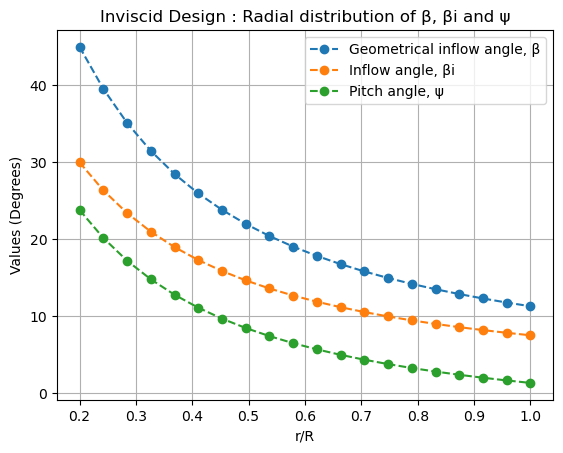

In [9]:
import matplotlib.pyplot as plt

plt.plot(df_res['r_R'], df_res['β'], label='Geometrical inflow angle, β',marker='o', linestyle='--')
plt.plot(df_res['r_R'], df_res['βi'], label='Inflow angle, βi',marker='o', linestyle='--')
plt.plot(df_res['r_R'], df_res['φ'], label='Pitch angle, ψ',marker='o', linestyle='--')

# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values (Degrees)')
plt.title('Inviscid Design : Radial distribution of β, βi and ψ')
plt.legend()

# Displaying the plot
plt.show()


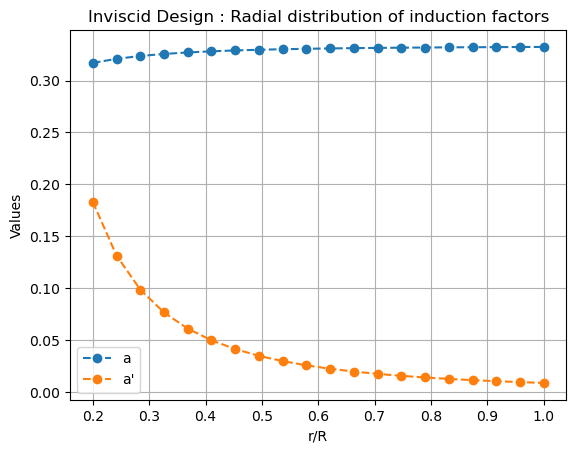

In [10]:
plt.plot(df_res['r_R'], df_res['a'], label='a',marker='o', linestyle='--')
plt.plot(df_res['r_R'], df_res['a1'], label='a\'',marker='o', linestyle='--')
# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values')
plt.title('Inviscid Design : Radial distribution of induction factors')
plt.legend()

# Displaying the plot
plt.show()

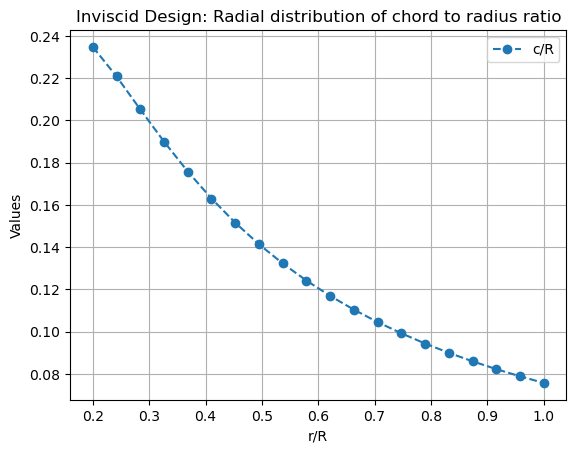

In [11]:
plt.plot(df_res['r_R'], df_res['c_R'], label='c/R',marker='o', linestyle='--')
# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values')
plt.title('Inviscid Design: Radial distribution of chord to radius ratio')
plt.legend()

# Displaying the plot
plt.show()

In [12]:
cp_inviscid = np.trapz((8/(tsr)**2)*(1-df_res['a']) * df_res['a1']*df_res['x']**3 , x=df_res['x'])

In [13]:
cp_inviscid

0.5537565702383623

### PART II: REAL FLOW DESIGN

In [14]:
df_real=pd.DataFrame()
df_real['x']=df_res['x']
df_real['r_R']=df_res['r_R']
df_real['FG']=z*CL_max*df_res['c_R']/df_res['r_R']
df_real

,x,r_R,FG
0,1.000000,0.200000,3.367149
1,1.210526,0.242105,2.615808
2,1.421053,0.284211,2.071025
3,1.631579,0.326316,1.669753
4,1.842105,0.368421,1.368852
5,2.052632,0.410526,1.139107
6,2.263158,0.452632,0.960644
7,2.473684,0.494737,0.819781
8,2.684211,0.536842,0.706956
9,2.894737,0.578947,0.615379


In [15]:

from scipy import optimize
from numpy import array

from scipy.optimize import least_squares

def equations(vars, FG, x):
    a, a1, βi = vars
    eq1=(a/(1-a))-((FG*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))/max_CL_CD)))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((FG*(1-(1/(np.tan(np.deg2rad(βi))*max_CL_CD))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    return [eq1, eq2, eq3]

def solve_equations(row):
    FG = row['FG']
    x = row['x']
    
    def f(p):
        return abs(sum(array(equations(p, FG, x)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_res.at[index, 'a'], df_res.at[index, 'a1'], df_res.at[index, 'βi']]
    
    # Define bounds
    bounds = ([1/4, 0, 0], [1/3, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars, FG, x)

    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)

    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, FG, x)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_real.at[index, 'eq1'], df_real.at[index, 'eq2'], df_real.at[index, 'eq3'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi'])

# Apply the function to each row of the DataFrame
df_real[['a', 'a1', 'βi']] = df_real.apply(solve_equations, axis=1)

df_real

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 107
Optimization terminated succ

,x,r_R,FG,eq1,eq2,eq3,a,a1,βi
0,1.000000,0.200000,3.367149,5.088818e-12,4.889394e-12,-6.474044e-12,0.317222,0.179284,30.069843
1,1.210526,0.242105,2.615808,-1.288775e-10,-1.207931e-10,2.147741e-10,0.321071,0.128406,26.428871
2,1.421053,0.284211,2.071025,-1.951450e-11,-1.364252e-11,2.876416e-11,0.323763,0.096108,23.467851
3,1.631579,0.326316,1.669753,-1.158668e-11,-6.170217e-12,1.677070e-11,0.325696,0.074411,21.039734
4,1.842105,0.368421,1.368852,-3.665512e-11,-2.339936e-11,6.393891e-11,0.327119,0.059182,19.027693
5,2.052632,0.410526,1.139107,2.223849e-11,2.639445e-11,-8.046136e-11,0.328191,0.048108,17.341961
6,2.263158,0.452632,0.960644,-9.246168e-08,2.554057e-07,-1.850255e-07,0.329016,0.039821,15.914288
7,2.473684,0.494737,0.819781,1.210754e-12,7.500535e-12,-4.476641e-12,0.329660,0.033467,14.692924
8,2.684211,0.536842,0.706956,-2.373979e-11,-1.639604e-11,6.575038e-11,0.330174,0.028493,13.638118
9,2.894737,0.578947,0.615379,4.150380e-11,4.395992e-11,-1.901386e-10,0.330589,0.024532,12.719320


In [16]:
df_real['φ']=df_real['βi']-corresponding_AoA
df_real['β']=np.rad2deg(np.arctan(1/df_real['x']))
df_real['f']=((z*df_real['x'])/(2*df_real['r_R']))-0.5
df_real['k']=(2/np.pi)*np.arccos(np.cosh(df_real['r_R']*df_real['f'])/np.cosh(df_real['f']))
df_real['c_R']=df_real['k']*df_res['c_R']

df_real

,x,r_R,FG,eq1,eq2,eq3,a,a1,βi,φ,β,f,k,c_R
0,1.000000,0.200000,3.367149,5.088818e-12,4.889394e-12,-6.474044e-12,0.317222,0.179284,30.069843,23.881687,45.000000,7.0,0.997503,0.234234
1,1.210526,0.242105,2.615808,-1.288775e-10,-1.207931e-10,2.147741e-10,0.321071,0.128406,26.428871,20.240715,39.559668,7.0,0.996732,0.220106
2,1.421053,0.284211,2.071025,-1.951450e-11,-1.364252e-11,2.876416e-11,0.323763,0.096108,23.467851,17.279696,35.134193,7.0,0.995676,0.204356
3,1.631579,0.326316,1.669753,-1.158668e-11,-6.170217e-12,1.677070e-11,0.325696,0.074411,21.039734,14.851578,31.504267,7.0,0.994241,0.188897
4,1.842105,0.368421,1.368852,-3.665512e-11,-2.339936e-11,6.393891e-11,0.327119,0.059182,19.027693,12.839537,28.495639,7.0,0.992303,0.174497
5,2.052632,0.410526,1.139107,2.223849e-11,2.639445e-11,-8.046136e-11,0.328191,0.048108,17.341961,11.153805,25.974394,7.0,0.989690,0.161380
6,2.263158,0.452632,0.960644,-9.246168e-08,2.554057e-07,-1.850255e-07,0.329016,0.039821,15.914288,9.726132,23.838740,7.0,0.986176,0.149522
7,2.473684,0.494737,0.819781,1.210754e-12,7.500535e-12,-4.476641e-12,0.329660,0.033467,14.692924,8.504769,22.011283,7.0,0.981450,0.138798
8,2.684211,0.536842,0.706956,-2.373979e-11,-1.639604e-11,6.575038e-11,0.330174,0.028493,13.638118,7.449963,20.432829,7.0,0.975100,0.129042
9,2.894737,0.578947,0.615379,4.150380e-11,4.395992e-11,-1.901386e-10,0.330589,0.024532,12.719320,6.531165,19.057705,7.0,0.966566,0.120076


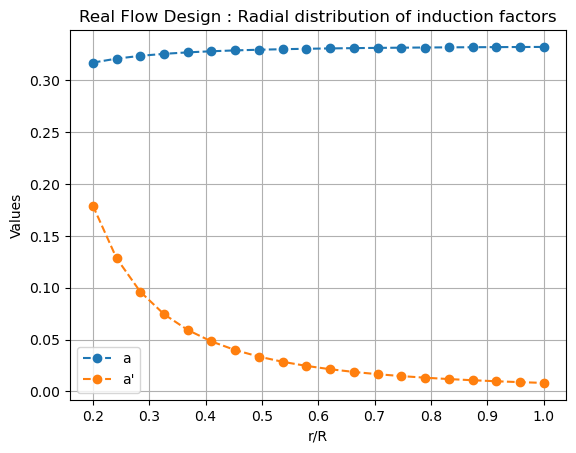

In [17]:
plt.plot(df_real['r_R'], df_real['a'], label='a',marker='o', linestyle='--')
plt.plot(df_real['r_R'], df_real['a1'], label='a\'',marker='o', linestyle='--')
# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values')
plt.title('Real Flow Design : Radial distribution of induction factors')
plt.legend()

# Displaying the plot
plt.show()

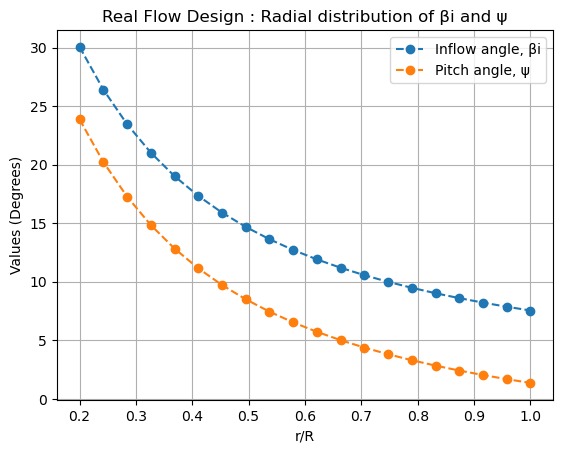

In [18]:
plt.plot(df_real['r_R'], df_real['βi'], label='Inflow angle, βi',marker='o', linestyle='--')
plt.plot(df_real['r_R'], df_real['φ'], label='Pitch angle, ψ',marker='o', linestyle='--')

# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values (Degrees)')
plt.title('Real Flow Design : Radial distribution of βi and ψ')
plt.legend()

# Displaying the plot
plt.show()

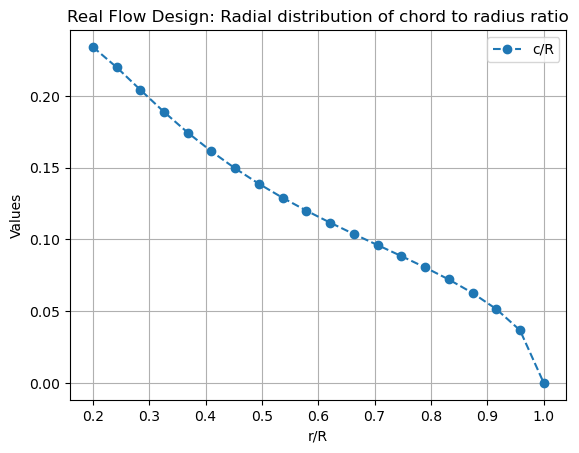

In [19]:
plt.plot(df_real['r_R'], df_real['c_R'], label='c/R',marker='o', linestyle='--')
# Adding labels and title
plt.grid(True)
plt.xlabel('r/R')
plt.ylabel('Values')
plt.title('Real Flow Design: Radial distribution of chord to radius ratio')
plt.legend()

# Displaying the plot
plt.show()

In [20]:
cp_real = (8/(tsr)**2)*np.trapz((1-df_real['a']) * df_real['a1']*df_real['x']**3 , x=df_real['x'])
cp_real 

0.5227148316265797

In [21]:
p_real=cp_real*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_real

9776582.145777268

In [22]:
ct_real = (8/(tsr)**2)*np.trapz((1-df_real['a']) * df_real['a']*df_real['x'] , x=df_real['x'])
ct_real 

0.8496011850112347

In [23]:
cq_real = cp_real /tsr
cq_real 

0.10454296632531594

### PART III: REAL FLOW ANALYSIS

In [24]:
tsr46=4.6
df_46=pd.DataFrame({'x': tsr46*r_R})
df_46['r_R']=df_real['r_R']
df_46['k']=df_real['k']
df_46['c_R']=df_real['c_R']
df_46['c_Ri']=df_res['c_R']
df_46['φ']=df_real['φ']
df_46

,x,r_R,k,c_R,c_Ri,φ
0,0.920000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.113684,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.307368,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.501053,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.694737,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.888421,0.410526,0.989690,0.161380,0.163061,11.153805
6,2.082105,0.452632,0.986176,0.149522,0.151618,9.726132
7,2.275789,0.494737,0.981450,0.138798,0.141421,8.504769
8,2.469474,0.536842,0.975100,0.129042,0.132337,7.449963
9,2.663158,0.578947,0.966566,0.120076,0.124230,6.531165


In [25]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_real.at[index, 'a'], df_real.at[index, 'a1'], df_real.at[index, 'βi'],df_real.at[index, 'βi']-df_46.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_46.at[index, 'eq1'], df_46.at[index, 'eq2'], df_46.at[index, 'eq3'], df_46.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_46[['a', 'a1', 'βi','AOA']] = df_46.apply(solve_equations, axis=1)

df_46

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 126
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 165
         Function evaluations: 285
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 124
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 161
         Function evaluations: 285
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 127
         Function evaluations: 220
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.920000,0.200000,0.997503,0.234234,0.234820,23.881687,1.156758e-11,2.363976e-11,-3.129230e-11,7.396740,0.324261,0.209064,31.278427
1,1.113684,0.242105,0.996732,0.220106,0.220828,20.240715,-6.336820e-12,-2.371436e-13,1.063405e-11,7.505938,0.326182,0.150146,27.746654
2,1.307368,0.284211,0.995676,0.204356,0.205243,17.279696,-1.306915e-10,-2.232631e-10,4.351643e-10,7.572529,0.326379,0.112438,24.852225
3,1.501053,0.326316,0.994241,0.188897,0.189991,14.851578,3.554651e-11,5.193948e-11,-1.145813e-10,7.607714,0.325526,0.086972,22.459292
4,1.694737,0.368421,0.992303,0.174497,0.175851,12.839537,-9.062817e-11,-1.734587e-10,4.410678e-10,7.620567,0.324054,0.069042,20.460104
5,1.888421,0.410526,0.989690,0.161380,0.163061,11.153805,4.078266e-11,5.958670e-11,-1.657719e-10,7.617907,0.322235,0.055988,18.771712
6,2.082105,0.452632,0.986176,0.149522,0.151618,9.726132,1.925998e-11,2.814063e-11,-8.574030e-11,7.604687,0.320240,0.046216,17.330819
7,2.275789,0.494737,0.981450,0.138798,0.141421,8.504769,9.730050e-12,1.913326e-11,-1.643824e-11,7.584372,0.318173,0.038728,16.089141
8,2.469474,0.536842,0.975100,0.129042,0.132337,7.449963,1.262018e-11,1.724158e-11,-6.196932e-11,7.559481,0.316103,0.032875,15.009444
9,2.663158,0.578947,0.966566,0.120076,0.124230,6.531165,3.333833e-12,2.180066e-11,-1.973971e-11,7.531735,0.314068,0.028220,14.062900


In [26]:
cp_46 = (8/(tsr46)**2)*np.trapz((1-df_46['a']) * df_46['a1']*df_46['x']**3 , x=df_46['x'])
cp_46

0.5212556681424882

In [27]:
p_46=cp_46*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_46

9749290.722608833

In [28]:
ct_46 = (8/(tsr46)**2)*np.trapz((1-df_46['a']) * df_46['a']*df_46['x'], x=df_46['x'])
ct_46

0.8204983065780698

In [29]:
cq_46=cp_46/tsr46
cq_46

0.11331644959619311

In [30]:
tsr42=4.2
df_42=pd.DataFrame({'x': tsr42*r_R})
df_42['r_R']=df_real['r_R']
df_42['k']=df_real['k']
df_42['c_R']=df_real['c_R']
df_42['c_Ri']=df_res['c_R']
df_42['φ']=df_real['φ']
df_42

,x,r_R,k,c_R,c_Ri,φ
0,0.840000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.016842,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.193684,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.370526,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.547368,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.724211,0.410526,0.989690,0.161380,0.163061,11.153805
6,1.901053,0.452632,0.986176,0.149522,0.151618,9.726132
7,2.077895,0.494737,0.981450,0.138798,0.141421,8.504769
8,2.254737,0.536842,0.975100,0.129042,0.132337,7.449963
9,2.431579,0.578947,0.966566,0.120076,0.124230,6.531165


In [31]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_46.at[index, 'a'], df_46.at[index, 'a1'], df_46.at[index, 'βi'],df_46.at[index, 'βi']-df_42.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_42.at[index, 'eq1'], df_42.at[index, 'eq2'], df_42.at[index, 'eq3'], df_42.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_42[['a', 'a1', 'βi','AOA']] = df_42.apply(solve_equations, axis=1)

df_42

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 136
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 140
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 127
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 151
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 161
         Function evaluations: 273
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 144
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 160
         Function evaluations: 278
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.840000,0.200000,0.997503,0.234234,0.234820,23.881687,-1.266354e-10,-2.417749e-10,2.989343e-10,8.931111,0.326083,0.244287,32.812797
1,1.016842,0.242105,0.996732,0.220106,0.220828,20.240715,1.629030e-12,3.431144e-13,7.860379e-14,9.231743,0.324411,0.175640,29.472459
2,1.193684,0.284211,0.995676,0.204356,0.205243,17.279696,2.401679e-11,4.500252e-11,-5.502787e-11,9.419991,0.320766,0.131392,26.699687
3,1.370526,0.326316,0.994241,0.188897,0.189991,14.851578,-6.332324e-11,-1.121217e-10,2.227547e-10,9.519056,0.316197,0.101395,24.370634
4,1.547368,0.368421,0.992303,0.174497,0.175851,12.839537,1.790562e-11,2.287368e-11,-5.070538e-11,9.552433,0.311315,0.080247,22.391970
5,1.724211,0.410526,0.989690,0.161380,0.163061,11.153805,6.510403e-12,7.126078e-12,-1.961614e-11,9.540033,0.306446,0.064855,20.693838
6,1.901053,0.452632,0.986176,0.149522,0.151618,9.726132,3.019807e-12,1.279872e-12,-3.198830e-12,9.497141,0.301752,0.053350,19.223273
7,2.077895,0.494737,0.981450,0.138798,0.141421,8.504769,-4.235445e-12,1.284526e-11,2.127576e-11,9.434729,0.297304,0.044553,17.939497
8,2.254737,0.536842,0.975100,0.129042,0.132337,7.449963,2.171985e-12,8.620465e-13,-7.772394e-12,9.360551,0.293127,0.037693,16.810514
9,2.431579,0.578947,0.966566,0.120076,0.124230,6.531165,-5.628398e-11,-8.149315e-11,2.755928e-10,9.279839,0.289220,0.032253,15.811004


In [32]:
cp_42 = (8/(tsr42)**2)*np.trapz((1-df_42['a']) * df_42['a1']*df_42['x']**3 , x=df_42['x'])
cp_42

0.5125522013145455

In [33]:
p_42=cp_42*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_42

9586505.675680574

In [34]:
ct_42 = (8/(tsr42)**2)*np.trapz((1-df_42['a']) * df_42['a']*df_42['x'] , x=df_42['x'])
ct_42

0.777670927385855

In [35]:
cq_42=cp_42/tsr42
cq_42

0.12203623840822511

In [36]:
tsr40=4
df_40=pd.DataFrame({'x': tsr40*r_R})
df_40['r_R']=df_real['r_R']
df_40['k']=df_real['k']
df_40['c_R']=df_real['c_R']
df_40['c_Ri']=df_res['c_R']
df_40['φ']=df_real['φ']
df_40

,x,r_R,k,c_R,c_Ri,φ
0,0.800000,0.200000,0.997503,0.234234,0.234820,23.881687
1,0.968421,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.136842,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.305263,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.473684,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.642105,0.410526,0.989690,0.161380,0.163061,11.153805
6,1.810526,0.452632,0.986176,0.149522,0.151618,9.726132
7,1.978947,0.494737,0.981450,0.138798,0.141421,8.504769
8,2.147368,0.536842,0.975100,0.129042,0.132337,7.449963
9,2.315789,0.578947,0.966566,0.120076,0.124230,6.531165


In [37]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_42.at[index, 'a'], df_42.at[index, 'a1'], df_42.at[index, 'βi'],df_42.at[index, 'βi']-df_40.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_40.at[index, 'eq1'], df_40.at[index, 'eq2'], df_40.at[index, 'eq3'], df_40.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_40[['a', 'a1', 'βi','AOA']] = df_40.apply(solve_equations, axis=1)

df_40

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 127
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 160
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 144
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 135
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 112
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 131
         Function evaluations: 226
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.800000,0.200000,0.997503,0.234234,0.234820,23.881687,3.852041e-11,3.527784e-11,-1.738043e-11,9.895827,0.323661,0.263951,33.777514
1,0.968421,0.242105,0.996732,0.220106,0.220828,20.240715,-1.056394e-11,-1.943226e-11,2.693734e-11,10.356268,0.318823,0.189509,30.596983
2,1.136842,0.284211,0.995676,0.204356,0.205243,17.279696,-2.732631e-11,-4.765904e-11,7.937451e-11,10.646735,0.312189,0.141408,27.926430
3,1.305263,0.326316,0.994241,0.188897,0.189991,14.851578,1.916689e-12,5.489720e-12,-7.584378e-12,10.794026,0.305154,0.108817,25.645604
4,1.473684,0.368421,0.992303,0.174497,0.175851,12.839537,2.633949e-12,1.873522e-11,-5.283829e-12,10.834516,0.298397,0.085894,23.674053
5,1.642105,0.410526,0.989690,0.161380,0.163061,11.153805,3.087486e-11,4.617590e-11,-7.600875e-11,10.802330,0.292159,0.069260,21.956135
6,1.810526,0.452632,0.986176,0.149522,0.151618,9.726132,-1.723305e-11,-2.401530e-11,6.459178e-11,10.724079,0.286475,0.056862,20.450211
7,1.978947,0.494737,0.981450,0.138798,0.141421,8.504769,4.173839e-11,5.449019e-11,-1.472887e-10,10.618407,0.281303,0.047406,19.123176
8,2.147368,0.536842,0.975100,0.129042,0.132337,7.449963,2.293510e-11,2.500082e-11,-7.457535e-11,10.497841,0.276584,0.040049,17.947803
9,2.315789,0.578947,0.966566,0.120076,0.124230,6.531165,5.265199e-11,8.467384e-11,-2.233096e-10,10.370389,0.272259,0.034223,16.901554


In [38]:
cp_40= (8/(tsr40)**2)*np.trapz((1-df_40['a']) * df_40['a1']*df_40['x']**3 , x=df_40['x'])
cp_40

0.5039319321251886

In [39]:
p_40=cp_40*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_40

9425276.713444684

In [40]:
ct_40= (8/(tsr40)**2)*np.trapz((1-df_40['a']) * df_40['a']*df_40['x'] , x=df_40['x'])
ct_40

0.7483415128407336

In [41]:
cq_40=cp_40/tsr40
cq_40

0.12598298303129715

In [42]:
tsr38=3.8
df_38=pd.DataFrame({'x': tsr38*r_R})
df_38['r_R']=df_real['r_R']
df_38['k']=df_real['k']
df_38['c_R']=df_real['c_R']
df_38['c_Ri']=df_res['c_R']
df_38['φ']=df_real['φ']
df_38

,x,r_R,k,c_R,c_Ri,φ
0,0.76,0.200000,0.997503,0.234234,0.234820,23.881687
1,0.92,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.08,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.24,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.40,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.56,0.410526,0.989690,0.161380,0.163061,11.153805
6,1.72,0.452632,0.986176,0.149522,0.151618,9.726132
7,1.88,0.494737,0.981450,0.138798,0.141421,8.504769
8,2.04,0.536842,0.975100,0.129042,0.132337,7.449963
9,2.20,0.578947,0.966566,0.120076,0.124230,6.531165


In [43]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_40.at[index, 'a'], df_40.at[index, 'a1'], df_40.at[index, 'βi'],df_40.at[index, 'βi']-df_38.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_38.at[index, 'eq1'], df_38.at[index, 'eq2'], df_38.at[index, 'eq3'], df_38.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_38[['a', 'a1', 'βi','AOA']] = df_38.apply(solve_equations, axis=1)

df_38

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 145
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 125
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 144
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 136
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 124
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 216
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.76,0.200000,0.997503,0.234234,0.234820,23.881687,-2.625594e-11,-4.822073e-11,5.556244e-11,11.091124,0.317172,0.284428,34.972810
1,0.92,0.242105,0.996732,0.220106,0.220828,20.240715,-6.185552e-12,-1.968373e-11,3.072076e-11,11.817290,0.306839,0.203037,32.058005
2,1.08,0.284211,0.995676,0.204356,0.205243,17.279696,-1.586337e-11,-2.878447e-11,4.835954e-11,12.276546,0.295430,0.150440,29.556242
3,1.24,0.326316,0.994241,0.188897,0.189991,14.851578,-3.181788e-12,-4.474823e-12,1.202460e-11,12.484204,0.285239,0.115084,27.335783
4,1.40,0.368421,0.992303,0.174497,0.175851,12.839537,-4.533596e-13,-4.525547e-13,8.646972e-13,12.505686,0.276865,0.090488,25.345223
5,1.56,0.410526,0.989690,0.161380,0.163061,11.153805,6.003831e-11,7.522699e-11,-1.563695e-10,12.411780,0.270029,0.072805,23.565585
6,1.72,0.452632,0.986176,0.149522,0.151618,9.726132,-5.892564e-12,-4.786539e-12,2.545786e-11,12.254537,0.264297,0.059708,21.980669
7,1.88,0.494737,0.981450,0.138798,0.141421,8.504769,-1.284028e-11,-2.124178e-11,4.419454e-11,12.066245,0.259335,0.049755,20.571014
8,2.04,0.536842,0.975100,0.129042,0.132337,7.449963,1.883382e-12,5.504049e-12,4.661438e-12,11.865796,0.254924,0.042024,19.315758
9,2.20,0.578947,0.966566,0.120076,0.124230,6.531165,-7.982226e-12,4.008995e-12,3.148237e-11,11.663745,0.250928,0.035908,18.194909


In [44]:
cp_38= (8/(tsr38)**2)*np.trapz((1-df_38['a']) * df_38['a1']*df_38['x']**3 , x=df_38['x'])
cp_38

0.4906994661985581

In [45]:
p_38=cp_38*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_38

9177783.659305904

In [46]:
ct_38= (8/(tsr38)**2)*np.trapz((1-df_38['a']) * df_38['a']*df_38['x'] , x=df_38['x'])
ct_38

0.7105344799475832

In [47]:
cq_38=cp_38/tsr38
cq_38

0.12913143847330477

In [48]:
tsr34=3.4
df_34=pd.DataFrame({'x': tsr34*r_R})
df_34['r_R']=df_real['r_R']
df_34['k']=df_real['k']
df_34['c_R']=df_real['c_R']
df_34['c_Ri']=df_res['c_R']
df_34['φ']=df_real['φ']
df_34

,x,r_R,k,c_R,c_Ri,φ
0,0.680000,0.200000,0.997503,0.234234,0.234820,23.881687
1,0.823158,0.242105,0.996732,0.220106,0.220828,20.240715
2,0.966316,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.109474,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.252632,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.395789,0.410526,0.989690,0.161380,0.163061,11.153805
6,1.538947,0.452632,0.986176,0.149522,0.151618,9.726132
7,1.682105,0.494737,0.981450,0.138798,0.141421,8.504769
8,1.825263,0.536842,0.975100,0.129042,0.132337,7.449963
9,1.968421,0.578947,0.966566,0.120076,0.124230,6.531165


In [49]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_38.at[index, 'a'], df_38.at[index, 'a1'], df_38.at[index, 'βi'],df_38.at[index, 'βi']-df_34.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_34.at[index, 'eq1'], df_34.at[index, 'eq2'], df_34.at[index, 'eq3'], df_34.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_34[['a', 'a1', 'βi','AOA']] = df_34.apply(solve_equations, axis=1)

df_34

Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 127
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 0.000460
         Iterations: 149
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 153
         Function evaluations: 262
Optimization terminated successfully.
         Current function value: 0.000449
         Iterations: 143
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: 0.000210
         Iterations: 149
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 173
         Function evaluations: 303
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 159
         Function evaluations: 278
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.680000,0.200000,0.997503,0.234234,0.234820,23.881687,3.458705e-03,6.098571e-03,-5.593907e-03,15.757452,0.258652,0.307183,39.639258
1,0.823158,0.242105,0.996732,0.220106,0.220828,20.240715,8.280709e-03,1.336871e-02,-1.457960e-02,16.182754,0.245207,0.218564,36.423736
2,0.966316,0.284211,0.995676,0.204356,0.205243,17.279696,9.330620e-03,1.394068e-02,-1.737619e-02,16.749775,0.224737,0.158302,34.029769
3,1.109474,0.326316,0.994241,0.188897,0.189991,14.851578,8.234361e-03,1.143755e-02,-1.581792e-02,17.485483,0.197766,0.114303,32.337332
4,1.252632,0.368421,0.992303,0.174497,0.175851,12.839537,5.724329e-03,7.392639e-03,-1.107626e-02,18.421481,0.163957,0.079704,31.261215
5,1.395789,0.410526,0.989690,0.161380,0.163061,11.153805,1.997343e-03,2.390445e-03,-3.802275e-03,19.591235,0.122483,0.050222,30.745112
6,1.538947,0.452632,0.986176,0.149522,0.151618,9.726132,-2.401884e-12,-3.106772e-12,6.350809e-12,17.816568,0.156976,0.050387,27.542700
7,1.682105,0.494737,0.981450,0.138798,0.141421,8.504769,-5.244916e-12,-6.466855e-12,1.321859e-11,16.608726,0.174981,0.046395,25.113495
8,1.825263,0.536842,0.975100,0.129042,0.132337,7.449963,-2.992218e-12,-2.075208e-12,7.378875e-12,15.833380,0.182373,0.040962,23.283342
9,1.968421,0.578947,0.966566,0.120076,0.124230,6.531165,-1.561390e-12,-2.795403e-13,3.481604e-12,15.229425,0.186015,0.035944,21.760589


In [50]:
cp_34= (8/(tsr34)**2)*np.trapz((1-df_34['a']) * df_34['a1']*df_34['x']**3 , x=df_34['x'])
cp_34

0.4301030253435487

In [51]:
p_34=cp_34*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_34

8044419.8327673925

In [52]:
ct_34= (8/(tsr34)**2)*np.trapz((1-df_34['a']) * df_34['a']*df_34['x'] , x=df_34['x'])
ct_34

0.5759249847572616

In [53]:
cq_34=cp_34/tsr34
cq_34

0.1265008898069261

In [54]:
tsr30=3
df_30=pd.DataFrame({'x': tsr30*r_R})
df_30['r_R']=df_real['r_R']
df_30['k']=df_real['k']
df_30['c_R']=df_real['c_R']
df_30['c_Ri']=df_res['c_R']
df_30['φ']=df_real['φ']
df_30

,x,r_R,k,c_R,c_Ri,φ
0,0.600000,0.200000,0.997503,0.234234,0.234820,23.881687
1,0.726316,0.242105,0.996732,0.220106,0.220828,20.240715
2,0.852632,0.284211,0.995676,0.204356,0.205243,17.279696
3,0.978947,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.105263,0.368421,0.992303,0.174497,0.175851,12.839537
5,1.231579,0.410526,0.989690,0.161380,0.163061,11.153805
6,1.357895,0.452632,0.986176,0.149522,0.151618,9.726132
7,1.484211,0.494737,0.981450,0.138798,0.141421,8.504769
8,1.610526,0.536842,0.975100,0.129042,0.132337,7.449963
9,1.736842,0.578947,0.966566,0.120076,0.124230,6.531165


In [55]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_34.at[index, 'a'], df_34.at[index, 'a1'], df_34.at[index, 'βi'],df_34.at[index, 'βi']-df_30.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, initial_guess, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_30.at[index, 'eq1'], df_30.at[index, 'eq2'], df_30.at[index, 'eq3'], df_30.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_30[['a', 'a1', 'βi','AOA']] = df_30.apply(solve_equations, axis=1)

df_30

Optimization terminated successfully.
         Current function value: 0.005428
         Iterations: 130
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 0.007317
         Iterations: 129
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: 0.007552
         Iterations: 135
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 0.006791
         Iterations: 138
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: 0.005522
         Iterations: 148
         Function evaluations: 257
Optimization terminated successfully.
         Current function value: 0.004046
         Iterations: 168
         Function evaluations: 290
Optimization terminated successfully.
         Current function value: 0.002562
         Iterations: 140
         Function evaluations: 246
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,0.600000,0.200000,0.997503,0.234234,0.234820,23.881687,2.739904e-02,5.268911e-02,-4.359735e-02,15.574879,2.748769e-01,0.394433,39.457483
1,0.726316,0.242105,0.996732,0.220106,0.220828,20.240715,3.223356e-02,5.641006e-02,-5.563138e-02,15.929047,2.635135e-01,0.288872,36.170751
2,0.852632,0.284211,0.995676,0.204356,0.205243,17.279696,3.300904e-02,5.325978e-02,-6.020702e-02,16.410697,2.457438e-01,0.216967,33.691381
3,0.978947,0.326316,0.994241,0.188897,0.189991,14.851578,3.160570e-02,4.733697e-02,-5.958326e-02,17.047666,2.222578e-01,0.164852,31.900207
4,1.105263,0.368421,0.992303,0.174497,0.175851,12.839537,2.896417e-02,4.035400e-02,-5.525684e-02,17.875890,1.928236e-01,0.124581,30.716348
5,1.231579,0.410526,0.989690,0.161380,0.163061,11.153805,2.545143e-02,3.293209e-02,-4.809395e-02,18.934522,1.566860e-01,0.091185,30.089183
6,1.357895,0.452632,0.986176,0.149522,0.151618,9.726132,2.104693e-02,2.517538e-02,-3.853166e-02,20.263861,1.127957e-01,0.061236,29.990744
7,1.484211,0.494737,0.981450,0.138798,0.141421,8.504769,1.542343e-02,1.693888e-02,-2.674977e-02,21.896178,6.014517e-02,0.032199,30.401527
8,1.610526,0.536842,0.975100,0.129042,0.132337,7.449963,7.996588e-03,7.969285e-03,-1.283474e-02,23.777538,1.740698e-22,0.002899,31.227812
9,1.736842,0.578947,0.966566,0.120076,0.124230,6.531165,4.906560e-08,8.382601e-08,-8.354070e-08,23.205406,7.331600e-03,0.000525,29.736571


In [56]:
cp_30= (8/(tsr30)**2)*np.trapz((1-df_30['a']) * df_30['a1']*df_30['x']**3 , x=df_30['x'])
cp_30

0.31493031789602427

In [57]:
p_30=cp_30*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_30

5890290.339620178

In [58]:
ct_30= (8/(tsr30)**2)*np.trapz((1-df_30['a']) * df_30['a']*df_30['x'] , x=df_30['x'])
ct_30

0.39172540302342024

In [59]:
cq_30=cp_30/tsr30
cq_30

0.1049767726320081

In [60]:
tsr54=5.4
df_54=pd.DataFrame({'x': tsr54*r_R})
df_54['r_R']=df_real['r_R']
df_54['k']=df_real['k']
df_54['c_R']=df_real['c_R']
df_54['c_Ri']=df_res['c_R']
df_54['φ']=df_real['φ']
df_54

,x,r_R,k,c_R,c_Ri,φ
0,1.080000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.307368,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.534737,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.762105,0.326316,0.994241,0.188897,0.189991,14.851578
4,1.989474,0.368421,0.992303,0.174497,0.175851,12.839537
5,2.216842,0.410526,0.989690,0.161380,0.163061,11.153805
6,2.444211,0.452632,0.986176,0.149522,0.151618,9.726132
7,2.671579,0.494737,0.981450,0.138798,0.141421,8.504769
8,2.898947,0.536842,0.975100,0.129042,0.132337,7.449963
9,3.126316,0.578947,0.966566,0.120076,0.124230,6.531165


In [61]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_real.at[index, 'a'], df_real.at[index, 'a1'], df_real.at[index, 'βi'],df_real.at[index, 'βi']-df_54.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_54.at[index, 'eq1'], df_54.at[index, 'eq2'], df_54.at[index, 'eq3'], df_54.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_54[['a', 'a1', 'βi','AOA']] = df_54.apply(solve_equations, axis=1)

df_54

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 124
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 139
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 129
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 126
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 122
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 122
         Function evaluations: 210
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,1.080000,0.200000,0.997503,0.234234,0.234820,23.881687,-3.038347e-12,1.834033e-11,6.393108e-12,5.191256,0.306991,0.154145,29.072942
1,1.307368,0.242105,0.996732,0.220106,0.220828,20.240715,-1.971862e-11,-2.945208e-11,5.776563e-11,5.125107,0.311951,0.110062,25.365822
2,1.534737,0.284211,0.995676,0.204356,0.205243,17.279696,-1.514794e-11,-3.275377e-11,7.432033e-11,5.087943,0.316452,0.082319,22.367638
3,1.762105,0.326316,0.994241,0.188897,0.189991,14.851578,2.617814e-10,3.651764e-10,-9.445230e-10,5.070290,0.320632,0.063783,19.921869
4,1.989474,0.368421,0.992303,0.174497,0.175851,12.839537,3.661349e-12,-3.006123e-12,1.108846e-11,5.065586,0.324559,0.050814,17.905123
5,2.216842,0.410526,0.989690,0.161380,0.163061,11.153805,-7.412071e-12,-1.112770e-11,3.683864e-11,5.069413,0.328271,0.041397,16.223218
6,2.444211,0.452632,0.986176,0.149522,0.151618,9.726132,1.086803e-11,1.180082e-11,-4.463918e-11,5.078834,0.331794,0.034351,14.804966
7,2.671579,0.494737,0.981450,0.138798,0.141421,8.504769,-1.231015e-12,3.516496e-11,1.023814e-11,5.091840,0.335142,0.028944,13.596609
8,2.898947,0.536842,0.975100,0.129042,0.132337,7.449963,-7.384093e-12,-1.532477e-11,6.749748e-11,5.107141,0.338333,0.024708,12.557103
9,3.126316,0.578947,0.966566,0.120076,0.124230,6.531165,-6.963985e-12,-2.016608e-11,9.678860e-11,5.123823,0.341379,0.021327,11.654988


In [62]:
cp_54= (8/(tsr54)**2)*np.trapz((1-df_54['a']) * df_54['a1']*df_54['x']**3 , x=df_54['x'])
cp_54

0.5194357286435165

In [63]:
p_54=cp_54*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_54

9715251.535397185

In [64]:
ct_54= (8/(tsr54)**2)*np.trapz((1-df_54['a']) * df_54['a']*df_54['x'] , x=df_54['x'])
ct_54

0.8695283573160949

In [65]:
cq_54=cp_54/tsr54
cq_54

0.0961918016006512

In [66]:
tsr58=5.8
df_58=pd.DataFrame({'x': tsr58*r_R})
df_58['r_R']=df_real['r_R']
df_58['k']=df_real['k']
df_58['c_R']=df_real['c_R']
df_58['c_Ri']=df_res['c_R']
df_58['φ']=df_real['φ']
df_58

,x,r_R,k,c_R,c_Ri,φ
0,1.160000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.404211,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.648421,0.284211,0.995676,0.204356,0.205243,17.279696
3,1.892632,0.326316,0.994241,0.188897,0.189991,14.851578
4,2.136842,0.368421,0.992303,0.174497,0.175851,12.839537
5,2.381053,0.410526,0.989690,0.161380,0.163061,11.153805
6,2.625263,0.452632,0.986176,0.149522,0.151618,9.726132
7,2.869474,0.494737,0.981450,0.138798,0.141421,8.504769
8,3.113684,0.536842,0.975100,0.129042,0.132337,7.449963
9,3.357895,0.578947,0.966566,0.120076,0.124230,6.531165


In [67]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_54.at[index, 'a'], df_54.at[index, 'a1'], df_54.at[index, 'βi'],df_54.at[index, 'βi']-df_58.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_58.at[index, 'eq1'], df_58.at[index, 'eq2'], df_58.at[index, 'eq3'], df_58.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_58[['a', 'a1', 'βi','AOA']] = df_58.apply(solve_equations, axis=1)

df_58

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 122
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 114
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 129
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 113
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 141
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 115
         Function evaluations: 200
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,1.160000,0.200000,0.997503,0.234234,0.234820,23.881687,-2.481515e-12,-2.547740e-12,3.357314e-11,4.346432,0.294583,0.132800,28.228119
1,1.404211,0.242105,0.996732,0.220106,0.220828,20.240715,6.355749e-12,5.737161e-12,-1.145406e-11,4.240263,0.300184,0.094535,24.480979
2,1.648421,0.284211,0.995676,0.204356,0.205243,17.279696,7.898571e-12,9.314355e-13,1.735001e-11,4.183756,0.306082,0.070669,21.463451
3,1.892632,0.326316,0.994241,0.188897,0.189991,14.851578,-8.397616e-12,-1.337117e-11,3.756762e-11,4.159560,0.312160,0.054813,19.011139
4,2.136842,0.368421,0.992303,0.174497,0.175851,12.839537,6.083950e-11,8.865723e-11,-2.796597e-10,4.156140,0.318304,0.043750,16.995677
5,2.381053,0.410526,0.989690,0.161380,0.163061,11.153805,-7.099321e-13,-7.199435e-12,3.546780e-11,4.165972,0.324431,0.035726,15.319777
6,2.625263,0.452632,0.986176,0.149522,0.151618,9.726132,2.094092e-11,2.847146e-11,-1.155377e-10,4.184174,0.330488,0.029720,13.910306
7,2.869474,0.494737,0.981450,0.138798,0.141421,8.504769,-1.959322e-12,-2.743637e-11,1.163191e-10,4.207514,0.336438,0.025106,12.712283
8,3.113684,0.536842,0.975100,0.129042,0.132337,7.449963,9.487255e-11,1.378946e-10,-6.494252e-10,4.233917,0.342267,0.021484,11.683880
9,3.357895,0.578947,0.966566,0.120076,0.124230,6.531165,3.199074e-11,4.262508e-11,-1.177932e-10,4.261975,0.347966,0.018587,10.793139


In [68]:
cp_58= (8/(tsr58)**2)*np.trapz((1-df_58['a']) * df_58['a1']*df_58['x']**3 , x=df_58['x'])
cp_58

0.512721007125511

In [69]:
p_58=cp_58*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_58

9589662.930416303

In [70]:
ct_58= (8/(tsr58)**2)*np.trapz((1-df_58['a']) * df_58['a']*df_58['x'] , x=df_58['x'])
ct_58

0.8827358742024508

In [71]:
cq_58=cp_58/tsr58
cq_58

0.0884001736423295

In [72]:
tsr62=6.2
df_62=pd.DataFrame({'x': tsr62*r_R})
df_62['r_R']=df_real['r_R']
df_62['k']=df_real['k']
df_62['c_R']=df_real['c_R']
df_62['c_Ri']=df_res['c_R']
df_62['φ']=df_real['φ']
df_62

,x,r_R,k,c_R,c_Ri,φ
0,1.240000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.501053,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.762105,0.284211,0.995676,0.204356,0.205243,17.279696
3,2.023158,0.326316,0.994241,0.188897,0.189991,14.851578
4,2.284211,0.368421,0.992303,0.174497,0.175851,12.839537
5,2.545263,0.410526,0.989690,0.161380,0.163061,11.153805
6,2.806316,0.452632,0.986176,0.149522,0.151618,9.726132
7,3.067368,0.494737,0.981450,0.138798,0.141421,8.504769
8,3.328421,0.536842,0.975100,0.129042,0.132337,7.449963
9,3.589474,0.578947,0.966566,0.120076,0.124230,6.531165


In [73]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_58.at[index, 'a'], df_58.at[index, 'a1'], df_58.at[index, 'βi'],df_58.at[index, 'βi']-df_62.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_62.at[index, 'eq1'], df_62.at[index, 'eq2'], df_62.at[index, 'eq3'], df_62.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_62[['a', 'a1', 'βi','AOA']] = df_62.apply(solve_equations, axis=1)

df_62

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 117
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 118
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 110
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 107
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 116
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 117
         Function evaluations: 205
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,1.240000,0.200000,0.997503,0.234234,0.234820,23.881687,4.059619e-11,5.933536e-11,-8.469192e-11,3.617310,0.280594,0.114537,27.498997
1,1.501053,0.242105,0.996732,0.220106,0.220828,20.240715,1.184143e-10,1.733039e-10,-3.703350e-10,3.488185,0.286537,0.081301,23.728900
2,1.762105,0.284211,0.995676,0.204356,0.205243,17.279696,7.388140e-11,1.034907e-10,-2.573356e-10,3.423781,0.293564,0.060769,20.703477
3,2.023158,0.326316,0.994241,0.188897,0.189991,14.851578,-7.852108e-12,2.275963e-11,1.044387e-11,3.400241,0.301297,0.047204,18.251820
4,2.284211,0.368421,0.992303,0.174497,0.175851,12.839537,-5.281026e-11,-5.301835e-12,3.462659e-10,3.402195,0.309441,0.037765,16.241732
5,2.545263,0.410526,0.989690,0.161380,0.163061,11.153805,1.134182e-10,1.685585e-10,-6.224254e-10,3.419865,0.317795,0.030922,14.573670
6,2.806316,0.452632,0.986176,0.149522,0.151618,9.726132,9.924728e-12,1.964172e-12,-7.671114e-12,3.447032,0.326228,0.025795,13.173164
7,3.067368,0.494737,0.981450,0.138798,0.141421,8.504769,-7.457146e-12,-1.207687e-11,5.296200e-11,3.479667,0.334655,0.021849,11.984435
8,3.328421,0.536842,0.975100,0.129042,0.132337,7.449963,-5.338729e-12,-7.323798e-12,3.632555e-11,3.515210,0.343033,0.018743,10.965173
9,3.589474,0.578947,0.966566,0.120076,0.124230,6.531165,1.462075e-11,-1.817394e-11,1.584089e-10,3.551962,0.351335,0.016252,10.083127


In [74]:
cp_62= (8/(tsr62)**2)*np.trapz((1-df_62['a']) * df_62['a1']*df_62['x']**3 , x=df_62['x'])
cp_62

0.5033017246329607

In [75]:
p_62=cp_62*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_62

9413489.645345857

In [76]:
ct_62= (8/(tsr62)**2)*np.trapz((1-df_62['a']) * df_62['a']*df_62['x'] , x=df_62['x'])
ct_62

0.8907099954616308

In [77]:
cq_62=cp_62/tsr62
cq_62

0.08117769752144528

In [78]:
tsr66=6.6
df_66=pd.DataFrame({'x': tsr66*r_R})
df_66['r_R']=df_real['r_R']
df_66['k']=df_real['k']
df_66['c_R']=df_real['c_R']
df_66['c_Ri']=df_res['c_R']
df_66['φ']=df_real['φ']
df_66

,x,r_R,k,c_R,c_Ri,φ
0,1.320000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.597895,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.875789,0.284211,0.995676,0.204356,0.205243,17.279696
3,2.153684,0.326316,0.994241,0.188897,0.189991,14.851578
4,2.431579,0.368421,0.992303,0.174497,0.175851,12.839537
5,2.709474,0.410526,0.989690,0.161380,0.163061,11.153805
6,2.987368,0.452632,0.986176,0.149522,0.151618,9.726132
7,3.265263,0.494737,0.981450,0.138798,0.141421,8.504769
8,3.543158,0.536842,0.975100,0.129042,0.132337,7.449963
9,3.821053,0.578947,0.966566,0.120076,0.124230,6.531165


In [79]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_62.at[index, 'a'], df_62.at[index, 'a1'], df_62.at[index, 'βi'],df_62.at[index, 'βi']-df_66.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_66.at[index, 'eq1'], df_66.at[index, 'eq2'], df_66.at[index, 'eq3'], df_66.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_66[['a', 'a1', 'βi','AOA']] = df_66.apply(solve_equations, axis=1)

df_66

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 127
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 114
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 118
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 138
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 106
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 100
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 123
         Function evaluations: 213
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,1.320000,0.200000,0.997503,0.234234,0.234820,23.881687,6.827061e-11,9.395508e-11,-1.663053e-10,2.979542,0.265405,0.098786,26.861229
1,1.597895,0.242105,0.996732,0.220106,0.220828,20.240715,-1.100246e-10,-1.445653e-10,3.470275e-10,2.839069,0.271490,0.069932,23.079785
2,1.875789,0.284211,0.995676,0.204356,0.205243,17.279696,4.530604e-11,6.429866e-11,-1.701372e-10,2.774353,0.279459,0.052290,20.054049
3,2.153684,0.326316,0.994241,0.188897,0.189991,14.851578,1.553052e-11,8.944114e-11,-4.654721e-12,2.756177,0.288670,0.040703,17.607755
4,2.431579,0.368421,0.992303,0.174497,0.175851,12.839537,3.073675e-11,3.996083e-11,-1.394827e-10,2.766203,0.298647,0.032659,15.605740
5,2.709474,0.410526,0.989690,0.161380,0.163061,11.153805,9.635180e-10,1.590506e-09,-5.134022e-09,2.793003,0.309072,0.026828,13.946808
6,2.987368,0.452632,0.986176,0.149522,0.151618,9.726132,-6.052714e-12,-2.263966e-11,1.237876e-10,2.829429,0.319739,0.022451,12.555561
7,3.265263,0.494737,0.981450,0.138798,0.141421,8.504769,5.679734e-12,1.234828e-12,-9.857754e-12,2.870928,0.330519,0.019073,11.375696
8,3.543158,0.536842,0.975100,0.129042,0.132337,7.449963,3.370881e-11,4.538980e-11,-2.474721e-10,2.914636,0.341341,0.016404,10.364599
9,3.821053,0.578947,0.966566,0.120076,0.124230,6.531165,6.411627e-11,8.913147e-11,-5.256276e-10,2.958678,0.352166,0.014255,9.489843


In [80]:
cp_66= (8/(tsr66)**2)*np.trapz((1-df_66['a']) * df_66['a1']*df_66['x']**3 , x=df_66['x'])
cp_66

0.491608580645578

In [81]:
p_66=cp_66*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_66

9194787.255786119

In [82]:
ct_66= (8/(tsr66)**2)*np.trapz((1-df_66['a']) * df_66['a']*df_66['x'] , x=df_66['x'])
ct_66

0.8944188761405903

In [83]:
cq_66=cp_66/tsr66
cq_66

0.07448614858266334

In [84]:
tsr70=7
df_70=pd.DataFrame({'x': tsr70*r_R})
df_70['r_R']=df_real['r_R']
df_70['k']=df_real['k']
df_70['c_R']=df_real['c_R']
df_70['c_Ri']=df_res['c_R']
df_70['φ']=df_real['φ']
df_70

,x,r_R,k,c_R,c_Ri,φ
0,1.400000,0.200000,0.997503,0.234234,0.234820,23.881687
1,1.694737,0.242105,0.996732,0.220106,0.220828,20.240715
2,1.989474,0.284211,0.995676,0.204356,0.205243,17.279696
3,2.284211,0.326316,0.994241,0.188897,0.189991,14.851578
4,2.578947,0.368421,0.992303,0.174497,0.175851,12.839537
5,2.873684,0.410526,0.989690,0.161380,0.163061,11.153805
6,3.168421,0.452632,0.986176,0.149522,0.151618,9.726132
7,3.463158,0.494737,0.981450,0.138798,0.141421,8.504769
8,3.757895,0.536842,0.975100,0.129042,0.132337,7.449963
9,4.052632,0.578947,0.966566,0.120076,0.124230,6.531165


In [85]:
def equations(vars, x, φ, c_R,r_R,k,c_Ri):
    a, a1, βi, AOA = vars
    eq1=(a/(1-a))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*np.cos(np.deg2rad(βi))*(1+(np.tan(np.deg2rad(βi))*( np.polyval(coeff_CD, AOA))/( np.polyval(coeff_CL, AOA)))))/(8*np.pi*(np.sin(np.deg2rad(βi)))**2))
    eq2=(a1/(1+a1))-((z*np.polyval(coeff_CL, AOA)*(c_Ri/r_R)*(1-(np.polyval(coeff_CD, AOA)/(np.tan(np.deg2rad(βi))*np.polyval(coeff_CL, AOA)))))/(8*np.pi*np.cos(np.deg2rad(βi))))
    eq3=np.tan(np.deg2rad(βi))-((1-a)/(x*(1+a1)))
    eq4=φ+AOA-βi
    return [eq1, eq2, eq3, eq4]

def solve_equations(row):
    x = row['x']
    φ = row['φ']
    c_R = row['c_R']
    r_R = row['r_R']
    k = row['k']
    c_Ri = row['c_Ri']
    
    def f(p):
        return abs(sum(array(equations(p, x, φ, c_R,r_R,k,c_Ri)) ** 2) - 0)
    
    index = row.name  # Get the index label of the row
    initial_guess = [df_66.at[index, 'a'], df_66.at[index, 'a1'], df_66.at[index, 'βi'],df_66.at[index, 'βi']-df_70.at[index, 'φ']]
    
    # Define bounds
    bounds = ([0, 0, 0, 0], [0.5, np.inf, np.inf, np.inf])

    # Use fmin for initial guess refinement
    result = optimize.fmin(f, initial_guess)
    
    # Define the objective function for least squares
    def objective(vars):
        return equations(vars,x, φ, c_R,r_R,k,c_Ri)
    
    # Perform least squares optimization
    solution = least_squares(objective, result, method='trf',bounds=bounds)
    
    # Calculate eq1, eq2, eq3
    eq_values = equations(solution.x, x, φ, c_R,r_R,k,c_Ri)
    
    
    # Update the original DataFrame with eq1, eq2, eq3
    df_70.at[index, 'eq1'], df_70.at[index, 'eq2'], df_70.at[index, 'eq3'], df_70.at[index, 'AOA'] = eq_values
    
    return pd.Series(solution.x, index=['a', 'a1', 'βi','AOA'])

# Apply the function to each row of the DataFrame
df_70[['a', 'a1', 'βi','AOA']] = df_70.apply(solve_equations, axis=1)

df_70

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 119
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 121
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 103
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 111
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 107
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 108
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 108
         Function evaluations: 185
Optimization termina

,x,r_R,k,c_R,c_Ri,φ,eq1,eq2,eq3,AOA,a,a1,βi
0,1.400000,0.200000,0.997503,0.234234,0.234820,23.881687,4.780287e-12,-2.018982e-11,3.861311e-11,2.415806,0.249278,0.085099,26.297493
1,1.694737,0.242105,0.996732,0.220106,0.220828,20.240715,-5.059836e-11,-8.306075e-11,1.874337e-10,2.272079,0.255365,0.060090,22.512794
2,1.989474,0.284211,0.995676,0.204356,0.205243,17.279696,1.156464e-12,5.949244e-11,-6.067924e-13,2.212150,0.264140,0.044972,19.491845
3,2.284211,0.326316,0.994241,0.188897,0.189991,14.851578,6.557088e-12,1.742834e-11,-2.560774e-11,2.202409,0.274695,0.035104,17.053988
4,2.578947,0.368421,0.992303,0.174497,0.175851,12.839537,3.105610e-11,3.040404e-11,-1.096335e-10,2.222228,0.286373,0.028271,15.061764
5,2.873684,0.410526,0.989690,0.161380,0.163061,11.153805,6.348427e-11,8.471616e-11,-3.459956e-10,2.258973,0.298739,0.023313,13.412778
6,3.168421,0.452632,0.986176,0.149522,0.151618,9.726132,-1.082562e-10,-4.107439e-11,8.000089e-10,2.304861,0.311517,0.019582,12.030993
7,3.463158,0.494737,0.981450,0.138798,0.141421,8.504769,8.801554e-11,1.028354e-10,-5.262889e-10,2.354999,0.324533,0.016691,10.859767
8,3.757895,0.536842,0.975100,0.129042,0.132337,7.449963,3.450873e-11,4.158232e-11,-2.404255e-10,2.406343,0.337695,0.014397,9.856306
9,4.052632,0.578947,0.966566,0.120076,0.124230,6.531165,-6.573209e-11,-9.307223e-11,9.356168e-10,2.456913,0.350952,0.012541,8.988078


In [86]:
cp_70= (8/(tsr70)**2)*np.trapz((1-df_70['a']) * df_70['a1']*df_70['x']**3 , x=df_70['x'])
cp_70

0.47789548756037303

In [87]:
p_70=cp_70*0.5*1.225*(u**3)*np.pi*(d/2)**2
p_70

8938304.805110274

In [88]:
ct_70= (8/(tsr70)**2)*np.trapz((1-df_70['a']) * df_70['a']*df_70['x'] , x=df_70['x'])
ct_70

0.8945266692842364

In [89]:
cq_70=cp_70/tsr70
cq_70

0.06827078393719614

#### RESULTS: REAL FLOW ANALYSIS

In [90]:
df_result=pd.DataFrame({'tsr':[3.4,3.8,4.2,4.6,5,5.4,5.8,6.2,6.6,7],
                    'cp':[cp_34,cp_38,cp_42,cp_46,cp_real,cp_54,cp_58,cp_62,cp_66,cp_70],
                    'p':[p_34,p_38,p_42,p_46,p_real,p_54,p_58,p_62,p_66,p_70],
                    'ct':[ct_34,ct_38,ct_42,ct_46,ct_real,ct_54,ct_58,ct_62,ct_66,ct_70],
                    'cq':[cq_34,cq_38,cq_42,cq_46,cq_real,cq_54,cq_58,cq_62,cq_66,cq_70],
                   })
df_result

,tsr,cp,p,ct,cq
0,3.4,0.430103,8.044420e+06,0.575925,0.126501
1,3.8,0.490699,9.177784e+06,0.710534,0.129131
2,4.2,0.512552,9.586506e+06,0.777671,0.122036
3,4.6,0.521256,9.749291e+06,0.820498,0.113316
4,5.0,0.522715,9.776582e+06,0.849601,0.104543
5,5.4,0.519436,9.715252e+06,0.869528,0.096192
6,5.8,0.512721,9.589663e+06,0.882736,0.088400
7,6.2,0.503302,9.413490e+06,0.890710,0.081178
8,6.6,0.491609,9.194787e+06,0.894419,0.074486
9,7.0,0.477895,8.938305e+06,0.894527,0.068271


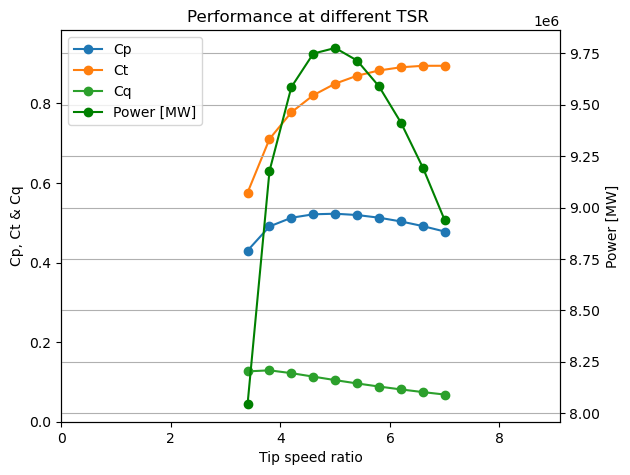

In [100]:
# Plotting
fig, ax1 = plt.subplots()

# Primary y-axis (cp and ct)
ax1.set_xlabel('Tip speed ratio')
ax1.set_ylabel('Cp, Ct & Cq')
ax1.plot(df_result['tsr'], df_result['cp'], marker='o', linestyle='-', label='Cp')
ax1.plot(df_result['tsr'], df_result['ct'], marker='o', linestyle='-', label='Ct')
ax1.plot(df_result['tsr'], df_result['cq'], marker='o', linestyle='-', label='Cq')

# Secondary y-axis (p)
ax2 = ax1.twinx()  
ax2.set_ylabel('Power [MW]')  
ax2.plot(df_result['tsr'], df_result['p'], marker='o', linestyle='-',color='g', label='Power [MW]')

# Set limits to ensure origin is at (0,0) and extend x-axis
max_tsr = df_result['tsr'].max()
max_cp_ct = max(df_result['cp'].max(), df_result['ct'].max())
max_p = df_result['p'].max()

ax1.set_xlim(0, max_tsr * 1.3)
ax1.set_ylim(0,max_cp_ct*1.1)
#ax2.set_ylim(0,max_p*1.2)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show plot
fig.tight_layout()  
plt.title('Performance at different TSR ')
plt.grid(True)
plt.show()